In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
import astropy.cosmology
from astropy.cosmology import Planck15 as cosmo
import emcee
import scipy.optimize as op

In [2]:
c=cte.c
c_um=c.to("um/s")
c_mm=c.to("mm/s")
Msun=cte.M_sun

In [3]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/SPT.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

z=[]

S3=[]
errS3=[]

S2=[]
errS2=[]

S1=[]
errS1=[]

S870=[]
errS870=[]

S500=[]
errS500=[]

S350=[]
errS350=[]

S250=[]
errS250=[]

S160=[]
errS160=[]

S100=[]
errS100=[]

for j in rows:   
    
    ID.append(j[0])
    z.append(float(j[1]))
    S3.append(float(j[2]))
    errS3.append(float(j[3]))
    S2.append(float(j[4]))
    errS2.append(float(j[5]))
    S1.append(float(j[6]))
    errS1.append(float(j[7]))
    S870.append(float(j[8]))
    errS870.append(float(j[9]))
    S500.append(float(j[10]))
    errS500.append(float(j[11]))
    S350.append(float(j[12]))
    errS350.append(float(j[13]))
    S250.append(float(j[14]))
    errS250.append(float(j[15]))
    S160.append(float(j[16]))
    errS160.append(float(j[17]))
    S100.append(float(j[18]))
    errS100.append(float(j[19]))
   

In [4]:
v__=np.array([870,500,350])*un.um
v_=(c_um/v__).to("Hz")
v=v_.value
l__=np.array([3.2,2,1.4])*un.mm
l_=(c_mm/l__).to("Hz")
l=l_.value
vf=np.concatenate((l,v))
print(vf)

[9.36851431e+10 1.49896229e+11 2.14137470e+11 3.44589032e+11
 5.99584916e+11 8.56549880e+11]


In [5]:
def prop(a,b,da1,da2,db1,db2,op):
    if op=="suma" or op=="resta":
        df1=np.sqrt(da1**2 + db1**2)
        df2=np.sqrt(da2**2 + db2**2)
    if op=="mult":
        df1=a*b*np.sqrt((da1/a)**2+(db1/b)**2)
        df2=a*b*np.sqrt((da2/a)**2+(db2/b)**2)
    if op=="div":
        df1=(a/b)*np.sqrt((da1/a)**2+(db1/b)**2)
        df2=(a/b)*np.sqrt((da2/a)**2+(db2/b)**2)
    if op=="exp":
        df1=(a**b) * np.sqrt(db1*db1*np.log10(a)*np.log10(a)+(b*da1/a**2)**2)
        df2=(a**b) * np.sqrt(db2*db2*np.log10(a)*np.log10(a)+(b*da2/a**2)**2)
    if op=="ln":
        df1=log10(np.e)*da1/a
        df2=log10(np.e)*da2/a
    return (df1,df2)

In [6]:
err1_z=prop(3.3,1,0.8,-0.7,0,0,"suma")

In [7]:
err1_d=prop(2.9,2,0.4,-0.4,0,0,"exp")
print(err1_d)

(0.8, 0.8)


In [8]:
errf_z=prop(3.3+1,2,err1_z[0],err1_z[1],0,0,"exp")
print(errf_z)

(1.6, 1.4)


In [9]:
err2_d=prop(1,2.9**2,0,0,err1_d[0],err1_d[1],"div")
print(err2_d)

(0.011310921684592122, 0.011310921684592122)


In [10]:
err3_d=prop(2*3/np.pi,1/(2.9**2),0,0,err2_d[0],err2_d[1],"div")
print(err3_d)

(1.5278874536821954, 1.5278874536821954)


In [11]:
def tau(z,M_,d_,vf): 
    v0=355*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [12]:
def P(vf,T,z):
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [13]:
def modelSv(z,T,M_,d_,vf):
    b=2
    v0=350*un.GHz
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    d=d_
    O=np.pi*(d/2)**2 * (D**-2)
    S_=O*(1-np.e**-tau(z,M_,d_,vf))*P(vf,T,z)
    S=S_.to("mJy")
    return S

In [14]:
#wrapper del modelo

def fit_bb(x, *p): #p not a list, x va en Hz
    #dejar una descripcion de los parametros que entran en la funcion entre comillas al comienzo
    """
    x : frecuencia *un.Hz ------> por alguna razon esto esta en Hz pero el v0 por ejemplo en GHz
    p = z T M d  ---------------> parametros a fitear   
    z : redshift (adimensional)
    T : temperatura en Kelvin pero sin usar unidades
    M : log(mu M/M_sun) (adimensional)
    d : distance *en kpc pero sin usar unidades
    
    return: modelo en mJy pero sin unidades
    """
    #queda definido dentro el valor de b y v0 que no se cambian nunca
    b = 2.0
    v0 = 353*un.GHz
    
    return modelSv(p[0],p[1]*un.K,p[2],p[3]*un.kpc,x)

In [15]:
ID[0]

'SPT0002-52'

In [16]:
def lnlike(theta,x,y,yerr):
    lnf,z,T,M,d = theta
    x = x*un.Hz
    modelSv = fit_bb(x,z,T,M,d).value
    inv_sigma2 = 1.0 / (yerr**2 + (modelSv)**2 * np.exp(2*lnf))
    return -0.5 * np.sum((y-(modelSv))**2*inv_sigma2 - np.log(inv_sigma2))

In [17]:
def lnlike_1(theta,x,y,yerr):
    lnf,z,T,M,d = theta
    x = x*un.Hz
    modelSv = fit_bb(x,z,T,M,d).value
    modelSv_corr=np.delete(modelSv,2)
    inv_sigma2 = 1.0 / (yerr**2 + (modelSv_corr)**2 * np.exp(2*lnf))
    return -0.5 * np.sum((y-(modelSv_corr))**2*inv_sigma2 - np.log(inv_sigma2))

In [85]:
def lnprior(theta):
    lnf,z,T,M,d = theta
    if T >= 2.73:
        return -1 * (T - 50)**2 / (2 * 10**2) #example gaussian
    return -np.inf

In [86]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [18]:
def ml(ID,z,T,M_,d_,frecsT,errfT): #recibe con unidades

    theta = [-1,z,T.value,M_,d_.value]
     

    n = lambda *args: -lnlike(*args)

    maxlike = op.minimize(n, theta, args=(vf,np.array(frecsT),np.array(errfT)))
    
    lnfM,zm,Tm,Mm,dm = maxlike["x"]
    
    plt.figure(figsize=(12,9))


    x0 = np.linspace(100,2000,100)*un.GHz
    x0 = x0.to("Hz")
    
        
    pm = [zm,Tm,Mm,dm]

    y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x0,y,label="MaxL")
    plt.errorbar(vf,np.array(frecsT),yerr=np.array(errfT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(zm,2),np.round(Tm,2),np.round(Mm,2),np.round(dm,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [19]:
def ml_1(ID,z,T,M_,d_,frecsT,errfT): #recibe con unidades

    theta = [-1,z,T.value,M_,d_.value]
     

    n = lambda *args: -lnlike_1(*args)

    maxlike = op.minimize(n, theta, args=(vf,np.array(frecsT),np.array(errfT)))
    
    lnfM,zm,Tm,Mm,dm = maxlike["x"]
    
    plt.figure(figsize=(12,9))


    x0 = np.linspace(100,2000,100)*un.GHz
    x0 = x0.to("Hz")
    
        
    pm = [zm,Tm,Mm,dm]

    y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x0,y,label="MaxL")
    plt.errorbar(np.delete(vf,2),np.array(frecsT),yerr=np.array(errfT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(zm,2),np.round(Tm,2),np.round(Mm,2),np.round(dm,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [20]:
z_spt1=[2.351,4.123,3.444,4.877,3.090,4.910,3.614,3.443,4.233,2.515,3.957,4.299,4.803,2.788,4.349,5.018]
z_spt2=[3.233,5.702,5.626,3.595,6.901,2.934,4.510,4.296,5.655,5.654,2.683,4.056,4.225,5.135,3.852,4.480]
z_spt3=[2.010,3.987,4.856,4.799,2.233,3.404,3.779,4.737,3.368,3.399,2.785,4.269,3.128,2.583,3.164,4.438]
z_spt4=[5.323,4.815,2.481,2.026,2.727,3.347,2.452,3.998,4.090,3.155,4.436,3.260,4.768,2.780,4.567,3.760]
z_spt5=[3.851,5.194,2.894,2.507,4.280,3.141,5.293,2.726,4.755,3.862,2.876,3.900,4.3032,5.811,5.578,1.867,3.070]
print((np.mean(z_spt1)+np.mean(z_spt2)+np.mean(z_spt3)+np.mean(z_spt4)+np.mean(z_spt5))/5)

3.8913280882352943


In [21]:
T_spt1=[59,50,52,58,33,66,58,56,31,66,68,43,48,37,30,67]
T_spt2=[64,34,60,44,57,47,59,71,79,63,60,55,58,69,51,51]
T_spt3=[21,43,56,49,34,63,43,58,32,44,42,53,35,62,44,36]
T_spt4=[59,62,42,53,39,40,37,35,33,52,44,56,51,61,47,48]
T_spt5=[47,53,45,35,61,48,60,64,61,55,49,63,59,70,66,61,43]
print((np.mean(T_spt1)+np.mean(T_spt2)+np.mean(T_spt3)+np.mean(T_spt4)+np.mean(T_spt5))/5)

51.28382352941177


In [22]:
M_spt1=np.array([0.96,1.93,2.04,1.74,2.85,1.94,0.33,0.20,0.48,4.38,0.86,1.34,2.27,2.06,6.20,2.31]) 
M_spt2=np.array([0.79,6.53,9.41,2.77,0.88,2.82,3.06,1.44,3.21,2.95,2.50,2.67,0.11,0.58,0.94,0.70])
M_spt3=np.array([7.11,0.30,1.28,2.14,2.53,0.52,1.30,0.66,1.15,3.56,1.05,2.17,1.13,2.25,1.91,1.33])
M_spt4=np.array([1.47,0.72,2.82,0.43,2.96,2.86,2.55,17.23,3.86,1.47,0.20,1.17,1.50,0.59,1.43,0.93])
M_spt5=np.array([1.79,0.67,1.32,1.51,1.48,0.30,0.46,1.57,0.17,0.48,2.49,0.12,0.99,0.40,0.67,1.39,1.29]) 
Mprom=(np.mean(M_spt1)+np.mean(M_spt2)+np.mean(M_spt3)+np.mean(M_spt4)+np.mean(M_spt5))/5
print(Mprom)

2.024051470588235


In [23]:
U_spt1=[5.5,5.48,5.49,5.5,5.34,5.5,12.25,5.5,23.86,5.47,14.17,5.5,5.5,5.5,5.5,8.28]
U_spt2=[5.5,5.09,1.00,3.53,2.0,5.5,2.88,7.95,5.57,1.18,5.5,1.66,32.70,5.5,5.5,12.73]
U_spt3=[1.71,5.5,4.97,3.64,5.5,5.5,5.5,5.5,13.23,10.04,20.10,5.5,5.5,5.5,5.5,5.5]
U_spt4=[5.5,5.5,5.5,5.5,5.5,5.5,3.89,5.5,6.25,5.5,27.84,5.5,5.72,21.00,6.65,6.55]
U_spt5=[5.5,5.5,5.5,5.5,1.95,5.5,7.89,5.5,5.5,3.37,2.15,5.5,1.00,5.5,5.5,6.29,2.85]
print((np.mean(U_spt1)+np.mean(U_spt2)+np.mean(U_spt3)+np.mean(U_spt4)+np.mean(U_spt5))/5)

6.749808823529412


In [24]:
z_ref=3.874
T_ref=51.28*un.K
M_ref= np.log10(6.749*2.02*10**9) # log10(Uprom*M/Msun) = log10(Uprom*Mprom*10**9)
d_ref=3.8*un.kpc
print(M_ref)

10.134590797588013


In [25]:
U_spt1=[5.5,5.48,5.49,5.5,5.34,5.5,12.25,5.5,23.86,5.47,14.17,5.5,5.5,5.5,5.5,8.28]
U_spt2=[5.5,5.09,1.00,3.53,2.0,5.5,2.88,7.95,5.57,1.18,5.5,1.66,32.70,5.5,5.5,12.73]
U_spt3=[1.71,5.5,4.97,3.64,5.5,5.5,5.5,5.5,13.23,10.04,20.10,5.5,5.5,5.5,5.5,5.5]
U_spt4=[5.5,5.5,5.5,5.5,5.5,5.5,3.89,5.5,6.25,5.5,27.84,5.5,5.72,21.00,6.65,6.55]
U_spt5=[5.5,5.5,5.5,5.5,1.95,5.5,7.89,5.5,5.5,3.37,2.15,5.5,1.00,5.5,5.5,6.29,2.85]
print((np.mean(U_spt1)+np.mean(U_spt2)+np.mean(U_spt3)+np.mean(U_spt4)+np.mean(U_spt5))/5)

6.749808823529412


In [26]:
ID[0]

'SPT0002-52'

In [27]:
print(np.log10(U_spt1[0]*M_spt1[0]*10**9))

9.722633922533813


In [28]:
z_ref=3.874
T_ref=51.28*un.K
M_ref=10.13
d_ref=3.8*un.kpc

In [29]:
frecs0T=np.array([S3[0],S2[0],S1[0],S870[0],S500[0],S350[0]])
errf0T=np.array([errS3[0],errS2[0],errS1[0],errS870[0],errS500[0],errS350[0]])

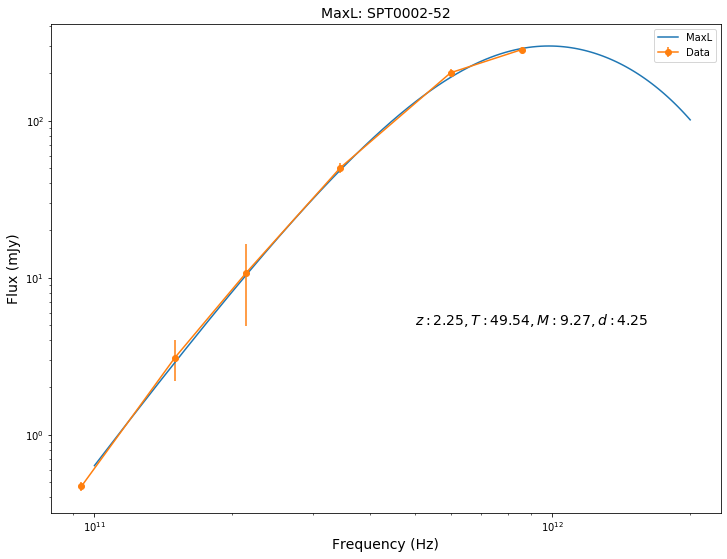

In [30]:
ml(ID[0],z_ref,T_ref,M_ref,d_ref,frecs0T,errf0T)

In [31]:
ID[1]

'SPT0020-51'

In [32]:
print(np.log10(U_spt1[1]*M_spt1[1]*10**9))

10.024337867492143


In [33]:
frecs1T=[S3[1],S2[1],S1[1],S870[1],S500[1],S350[1]]
errf1T=[errS3[1],errS2[1],errS1[1],errS870[1],errS500[1],errS350[1]]

In [34]:
print(errS350[0])

8.9


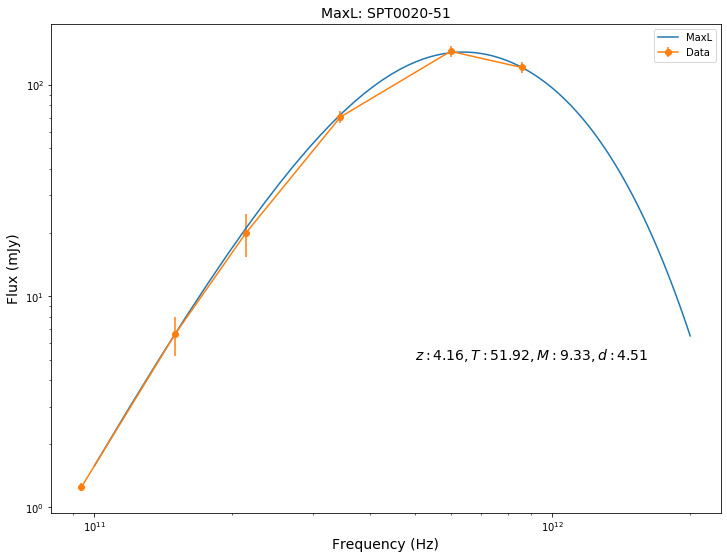

In [35]:
ml(ID[1],z_ref,T_ref,M_ref,d_ref,frecs1T,errf1T)

In [36]:
ID[2]

'SPT0027-50'

In [37]:
print(np.log10(U_spt1[2]*M_spt1[2]*10**9))

10.04920251187599


In [38]:
frecs2T=[S3[2],S2[2],S1[2],S870[2],S500[2],S350[2]]
errf2T=[errS3[2],errS2[2],errS1[2],errS870[2],errS500[2],errS350[2]]

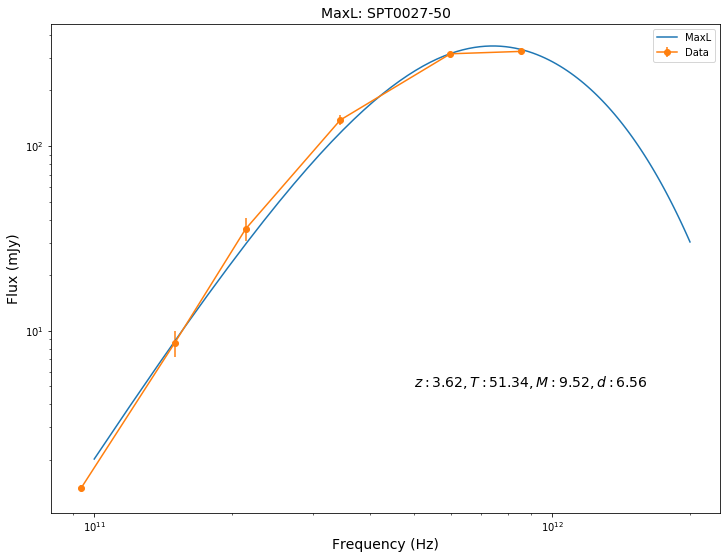

In [39]:
ml(ID[2],z_ref,T_ref,M_ref,d_ref,frecs2T,errf2T)

In [40]:
ID[3]

'SPT0054-41'

In [41]:
print(np.log10(U_spt1[3]*M_spt1[3]*10**9))

9.980911937776844


In [42]:
frecs3T=[S3[3],S2[3],S1[3],S870[3],S500[3],S350[3]]
errf3T=[errS3[3],errS2[3],errS1[3],errS870[3],errS500[3],errS350[3]]

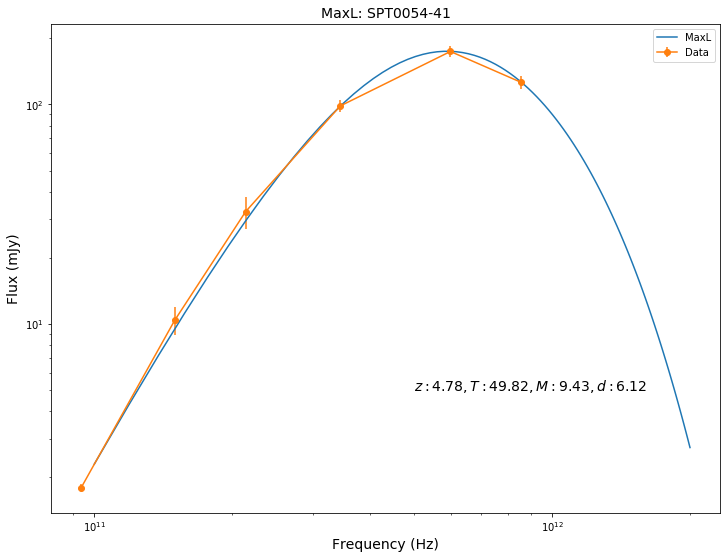

In [43]:
ml(ID[3],z_ref,T_ref,M_ref,d_ref,frecs3T,errf3T)

In [44]:
ID[4]

'SPT0103-45'

In [45]:
print(np.log10(U_spt1[4]*M_spt1[4]*10**9))

10.182386117037067


In [46]:
frecs4T=[S3[4],S2[4],S1[4],S870[4],S500[4],S350[4]]
errf4T=[errS3[4],errS2[4],errS1[4],errS870[4],errS500[4],errS350[4]]

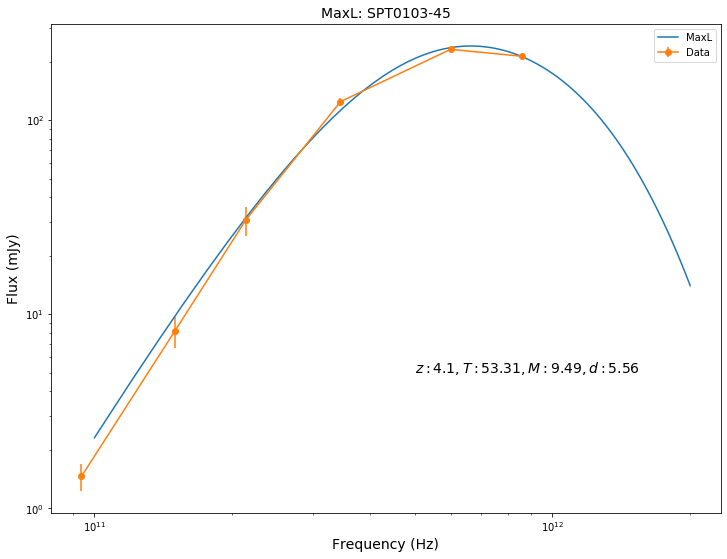

In [47]:
ml(ID[4],z_ref,T_ref,M_ref,d_ref,frecs4T,errf4T)

In [48]:
ID[5]

'SPT0106-64'

In [49]:
print(np.log10(U_spt1[5]*M_spt1[5]*10**9))

10.02816441942447


In [50]:
frecs5T=[S3[5],S2[5],S1[5],S870[5],S500[5],S350[5]]
errf5T=[errS3[5],errS2[5],errS1[5],errS870[5],errS500[5],errS350[5]]

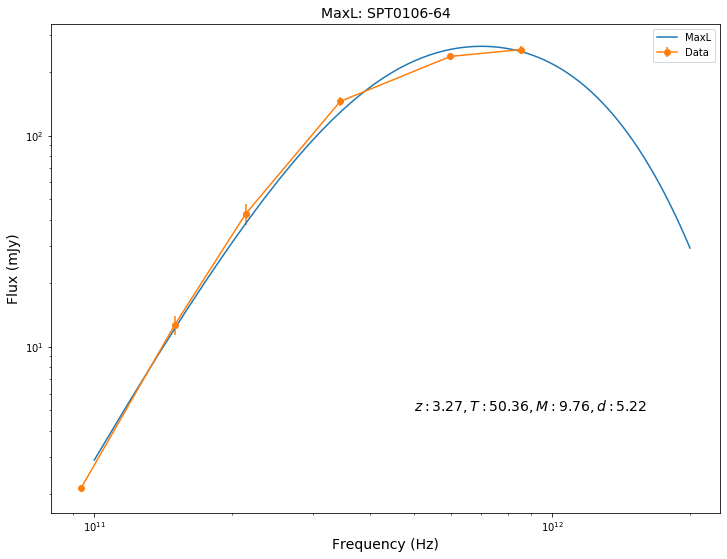

In [51]:
ml(ID[5],z_ref,T_ref,M_ref,d_ref,frecs5T,errf5T)

In [52]:
ID[6]

'SPT0109-47'

In [53]:
print(np.log10(U_spt1[6]*M_spt1[6]*10**9))

9.60665002857844


In [54]:
frecs6T=[S3[6],S2[6],S1[6],S870[6],S500[6],S350[6]]
errf6T=[errS3[6],errS2[6],errS1[6],errS870[6],errS500[6],errS350[6]]

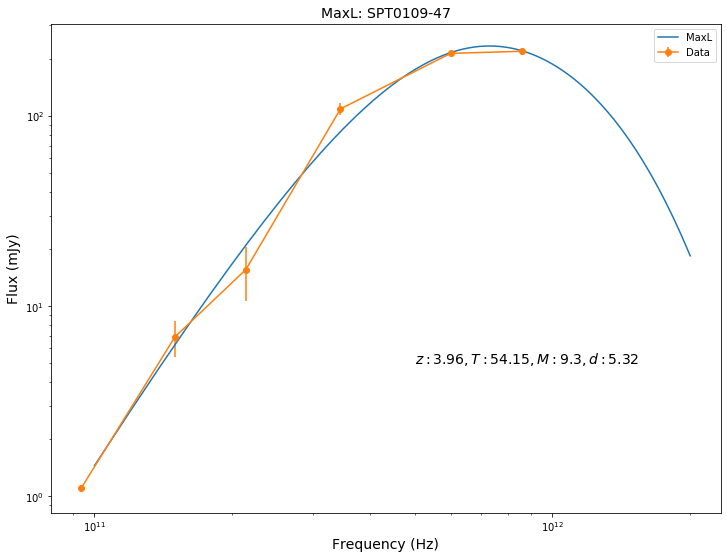

In [55]:
ml(ID[6],z_ref,T_ref,M_ref,d_ref,frecs6T,errf6T)

In [56]:
ID[7]

'SPT0112-55'

In [57]:
print(np.log10(U_spt1[7]*M_spt1[7]*10**9))

9.041392685158225


In [58]:
frecs7T=[S3[7],S2[7],S1[7],S870[7],S500[7],S350[7]]
errf7T=[errS3[7],errS2[7],errS1[7],errS870[7],errS500[7],errS350[7]]

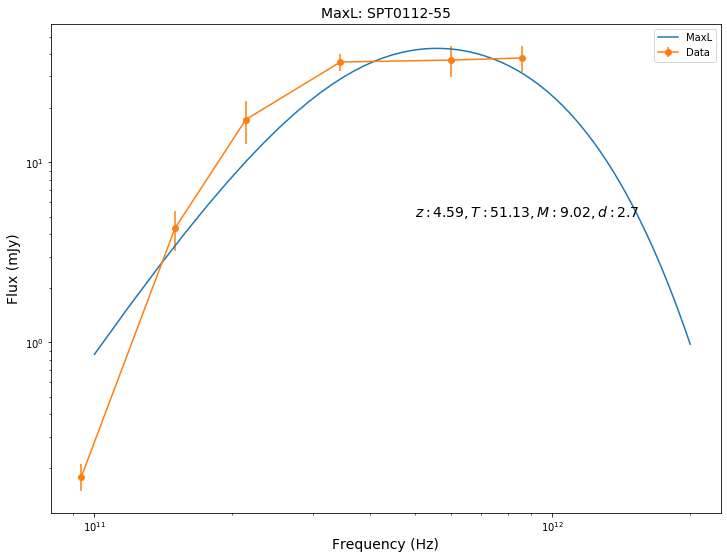

In [59]:
ml(ID[7],z_ref,T_ref,M_ref,d_ref,frecs7T,errf7T)

In [60]:
ID[8]

'SPT0113-46'

In [61]:
print(np.log10(U_spt1[8]*M_spt1[8]*10**9))

10.05891167670991


In [62]:
frecs8T=[S3[8],S2[8],S1[8],S870[8],S500[8],S350[8]]
errf8T=[errS3[8],errS2[8],errS1[8],errS870[8],errS500[8],errS350[8]]

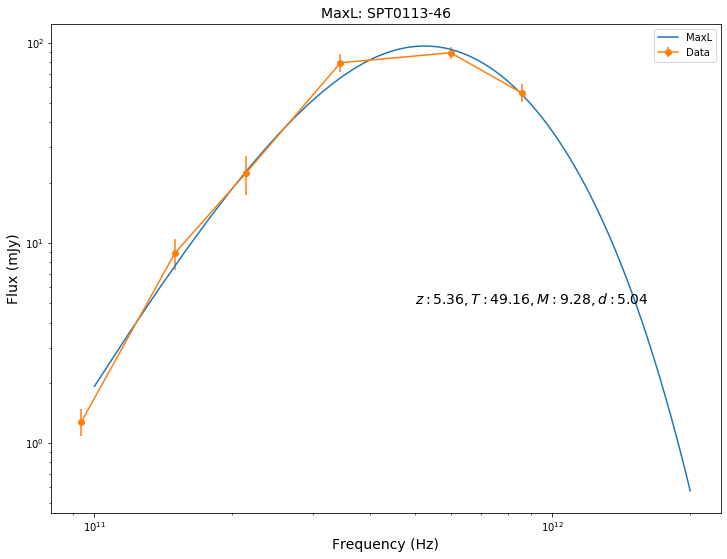

In [63]:
ml(ID[8],z_ref,T_ref,M_ref,d_ref,frecs8T,errf8T)

In [64]:
ID[9]

'SPT0125-47'

In [65]:
print(np.log10(U_spt1[9]*M_spt1[9]*10**9))

10.37946143683753


In [66]:
frecs9T=[S3[9],S2[9],S1[9],S870[9],S500[9],S350[9]]
errf9T=[errS3[9],errS2[9],errS1[9],errS870[9],errS500[9],errS350[9]]

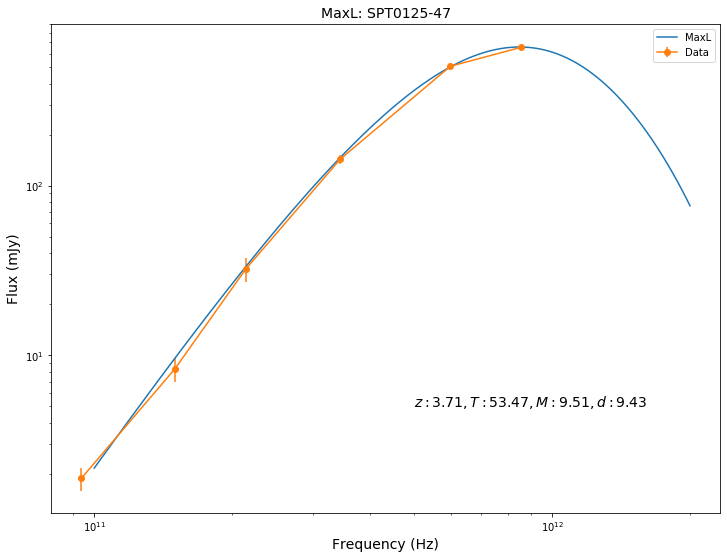

In [67]:
ml(ID[9],z_ref,T_ref,M_ref,10.37*un.kpc,frecs9T,errf9T) #cambiar distancia

In [68]:
ID[10]

'SPT0125-50'

In [69]:
print(np.log10(U_spt1[10]*M_spt1[10]*10**9))

10.085868301491027


In [70]:
frecs10T=[S3[10],S2[10],S1[10],S870[10],S500[10],S350[10]]
errf10T=[errS3[10],errS2[10],errS1[10],errS870[10],errS500[10],errS350[10]]

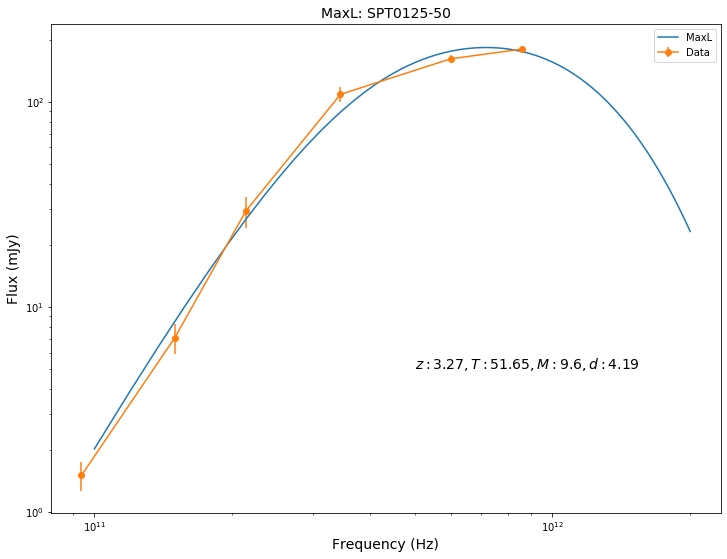

In [71]:
ml(ID[10],z_ref,T_ref,M_ref,d_ref,frecs10T,errf10T) 

In [72]:
ID[11]

'SPT0136-63'

In [73]:
print(np.log10(U_spt1[11]*M_spt1[11]*10**9))

9.867467487859052


In [74]:
frecs11T=[S3[11],S2[11],S1[11],S870[11],S500[11],S350[11]]
errf11T=[errS3[11],errS2[11],errS1[11],errS870[11],errS500[11],errS350[11]]

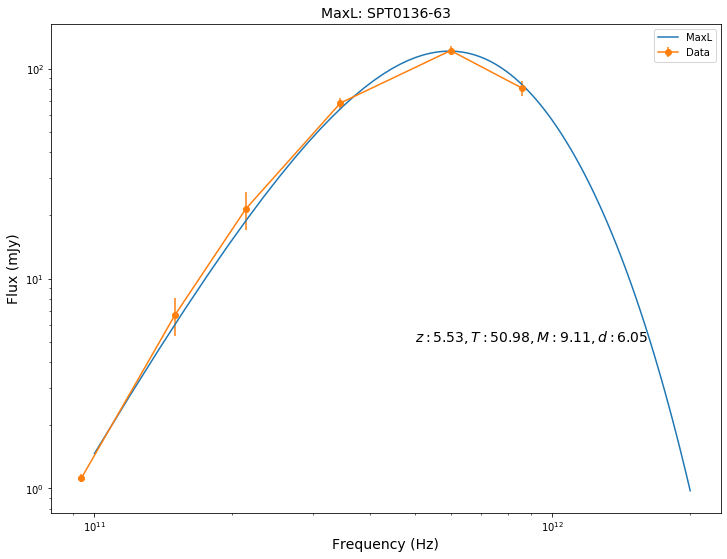

In [75]:
ml(ID[11],z_ref,T_ref,M_ref,d_ref,frecs11T,errf11T) 

In [76]:
ID[12]

'SPT0147-64'

In [77]:
print(np.log10(U_spt1[12]*M_spt1[12]*10**9))

10.096388546687367


In [78]:
frecs12T=[S3[12],S2[12],S1[12],S870[12],S500[12],S350[12]]
errf12T=[errS3[12],errS2[12],errS1[12],errS870[12],errS500[12],errS350[12]]

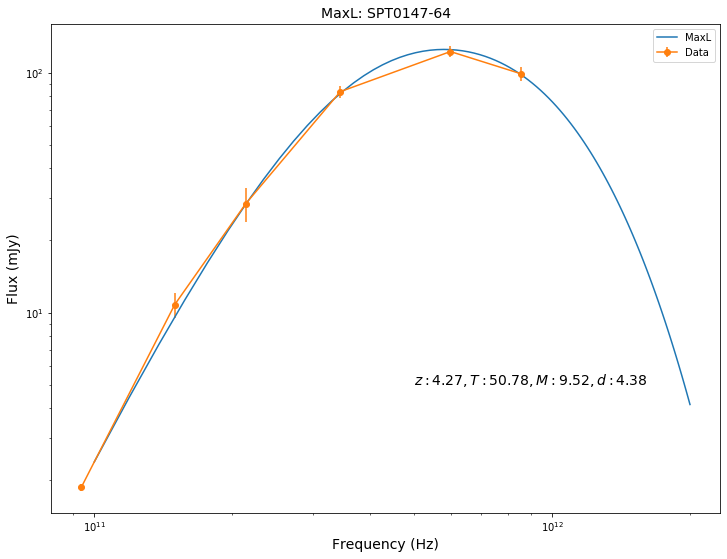

In [79]:
ml(ID[12],z_ref,T_ref,M_ref,d_ref,frecs12T,errf12T) 

In [80]:
ID[13]

'SPT0150-59'

In [81]:
print(np.log10(U_spt1[13]*M_spt1[13]*10**9))

10.054229909863396


In [82]:
frecs13T=[S3[13],S2[13],S1[13],S870[13],S500[13],S350[13]]
errf13T=[errS3[13],errS2[13],errS1[13],errS870[13],errS500[13],errS350[13]]

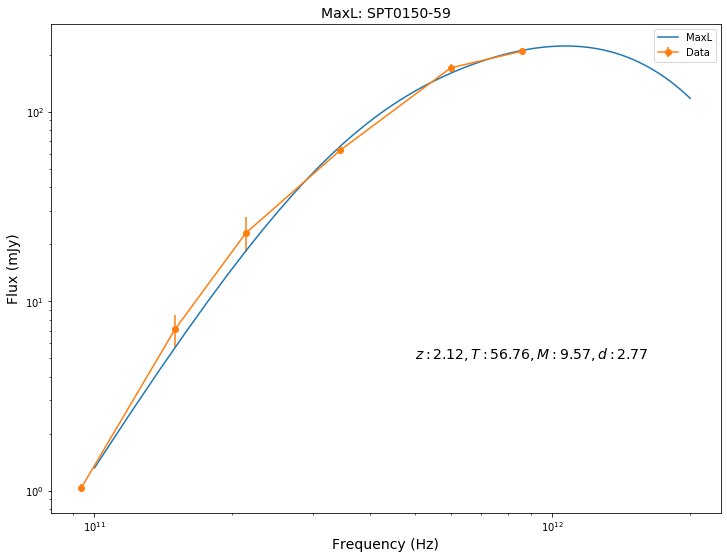

In [83]:
ml(ID[13],z_ref,T_ref,M_ref,d_ref,frecs13T,errf13T) 

In [109]:
def mcmc(ID,z,T,M_,d_,frecsT,errfT): #recibe con unidades

    theta = [-1,z,T.value,M_,d_.value]
     

    n = lambda *args: -lnlike(*args)

    maxlike = op.minimize(n, theta, args=(vf,np.array(frecsT),np.array(errfT)))
    
    lnfM,zm,Tm,Mm,dm = maxlike["x"]
    
    plt.figure(figsize=(12,9))


    x0 = np.linspace(100,2000,100)*un.GHz
    x0 = x0.to("Hz")
    
        
    pm = [zm,Tm,Mm,dm]

    y = fit_bb(x0,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 5, 300
    pos = [maxlike["x"] + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
    #print(pos[1])
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob([-1,z,T.value,M_,d_.value], vf, np.array(frecsT), np.array(errfT)),args=(vf,np.array(frecsT),np.array(errfT)),
                                threads=2)
    sampler.run_mcmc(pos, 1000)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["ln","z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    truths=[lnfM,zm,Tm,Mm,dm])

In [110]:
mcmc(ID[11],z_ref,T_ref,M_ref,d_ref,frecs11T,errf11T)

emcee: Exception while calling your likelihood function:
  params: [-11.23492587   5.53305718  50.97848827   9.11096362   6.05283178]
  args: (array([9.36851431e+10, 1.49896229e+11, 2.14137470e+11, 3.44589032e+11,
       5.99584916e+11, 8.56549880e+11]), array([  1.12,   6.7 ,  21.5 ,  68.7 , 122.1 ,  81.1 ]), array([0.05, 1.4 , 4.4 , 4.1 , 6.3 , 6.8 ]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
TypeError: 'numpy.float64' object is not callable


TypeError: 'numpy.float64' object is not callable

<Figure size 864x648 with 0 Axes>